# Etape 1 - Visualisation des données
Dans ce notebook, on traite la première partie de la méthode, qui consiste en la visualisation, la sélection et le formattage des données que l'on va utiliser par la suite.

In [1]:
# Modules
import pandas as pd
import pyedflib
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

import Visualisation as visu

import warnings
warnings.filterwarnings('ignore')

## Initialisation

In [2]:
# Paramètres généraux
# patients_path = 'C:/Users/alexi/Desktop/Data'
patients_path = 'C:/Users/Alexia/Desktop/Data'
description_path = f'{patients_path}/description.csv'
Duree_D = 120

In [3]:
# Chargement de la description des données
try:
    description = pd.read_csv(description_path, delimiter=';')
except FileNotFoundError:
    print(f"{description_path} n'existe pas")
    exit()

In [4]:
# Vérifie si le DataFrame de description contient les colonnes requises
assert isinstance(description, pd.DataFrame) and 'Enregistrement' in description.columns and 'Duree D' in description.columns, "description should be a DataFrame with 'Enregistrement' and 'Duree D' columns"

In [5]:
# Selection du patient voulu
patients = [f'chb{i:02d}' for i in range(1, 24)]
patient_nb = 1
if patient_nb < 1 or patient_nb > len(patients):
    print(f"Patient {patient_nb} n'existe pas")
    exit()
patient = patients[patient_nb - 1]

In [6]:
# Vérifie si le nom du patient est une chaîne de caractères
if not isinstance(patient, str):
    raise TypeError("patient should be a string")

In [7]:
# Vérifie si le DataFrame de description contient les colonnes requises
if not isinstance(description, pd.DataFrame) or 'Enregistrement' not in description.columns or 'Duree D' not in description.columns:
    raise TypeError("description should be a DataFrame with 'Enregistrement' and 'Duree D' columns")

In [8]:
# Créer le chemin vers le dossier contenant les données du patient
chemins_donnees = f'{patients_path}/{patient}/'

In [9]:
# Liste des fichiers .edf dans le dossier du patient
donnees = [os.path.join(chemins_donnees, f) for f in os.listdir(chemins_donnees) if f.endswith('.edf')]

In [10]:
# Filtrer la description pour ne garder que les enregistrements du patient donné
informations = description[description['Enregistrement'].str.startswith(patient)]

## Sélection des données

In [11]:
# Initialisation des listes pour les noms d'enregistrements à concaténer et pour les noms finaux des enregistrements
to_concat = []
noms_fin = []

In [12]:
# Définition des liste des noms des enregistrements ayant la durée D recherchée et des index associés
enr_list = informations[informations['Duree D']==Duree_D].Enregistrement
enr_index = informations[informations.Enregistrement.isin(enr_list)].index.values

In [13]:
# Boucle sur les index pour chaque enregistrement
for idx in enr_index:
    # Nom de l'enregistrement contenant la crise
    name_enr=[informations['Enregistrement'].loc[idx]]
    name_fin=informations['Enregistrement'].loc[idx]
    iter = 1
    # On regarde l'enregistrement précédent
    row = informations.loc[idx-iter]
    # Si l'enregistrement de crise a une durée d'avant crise plus courte que la durée D, on cherche les enregistrement d'avant
    while informations.loc[idx]['D manquant']>0 and row['Duree']==row['A concatener']:
        # On ajoute les noms des enregistrements précédents
        name_enr.append(row.Enregistrement)
        iter+=1
        row = informations.loc[idx-iter]
        if row['A concatener'] > 0:
            name_enr.append(row.Enregistrement)
    # On inverse la liste des noms d'enregistrements pour qu'ils soient dans l'ordre de la concaténation
    name_enr.reverse()
    # On créer les listes globales
    to_concat.append(name_enr)
    noms_fin.append(name_fin)

## Lecture des données sélectionnées

In [14]:
# Paramètres d'étude
crise_nb = 1
liste_crise = to_concat[crise_nb - 1]

In [15]:
# Liste des DataFrames pour chaque fichier EDF de la liste
DF = []

In [16]:
# Parcourt les fichiers EDF et les traite s'ils sont dans la liste donnée
sample_freq = None
for filepath in donnees:
    filename = os.path.basename(filepath)
    # Si le nom de fichier est dans la liste
    if filename in liste_crise:
        try:
            # Ouvre le fichier EDF avec pyedflib
            with pyedflib.EdfReader(filepath) as f:
                # Obtient les noms des canaux et la fréquence d'échantillonnage
                channel_names = f.getSignalLabels()
                curr_sample_freq = f.getSampleFrequency(0)
                # Vérifie que tous les fichiers ont la même fréquence d'échantillonnage
                if sample_freq is None:
                    sample_freq = curr_sample_freq
                elif sample_freq != curr_sample_freq:
                    sample_freq = None
                # Lit les données pour chaque canal et les stocke dans un dictionnaire
                data = {}
                for i, channel in enumerate(channel_names):
                    data[channel] = f.readSignal(i)
                # Crée un DataFrame à partir du dictionnaire et ajoute le nom de fichier en tant que colonne
                df = pd.DataFrame.from_dict(data)
                df['Nom'] = filename
                # Ajoute le DataFrame à la liste
                DF.append(df)
        # S'il y a une erreur, passe au fichier suivant
        except (AssertionError, ValueError):
            continue

## Formattage des données

In [17]:
# Initialise la liste de DataFrames formatés
DF_format = []

In [18]:
# Réinitialisation de l'index de informations
informations = informations.reset_index()

In [19]:
# Formatage des données de chaque fichier EDF
for index, df in enumerate(DF):
    # Définition du temps de début et de fin
    t_debut = 0
    t_fin = len(df) / sample_freq
    # Création de la colonne "time"
    df['time'] = np.linspace(t_debut, t_fin, len(df), endpoint=False)
    # Récupération des informations pour le fichier EDF actuel
    information = informations[informations['Enregistrement'] == df['Nom'][0]]
    if information['Nb crises'].values[0] >= 2:
        information = informations.loc[(informations['Duree D'] == 120) & (informations['Enregistrement'] == df['Nom'][0])]
    # Définition du temps de début du fichier EDF actuel
    debut = information['Debut sec'].values[0]
    # Ajout du temps de début au temps de chaque ligne de la colonne "time"
    df['time'] += debut
    # On enlève les colonnes inutiles
    df = df.loc[:, (df != 0).any(axis=0)]
    # Ajout de la colonne "label" initialisée à 0
    df['label'] = 0
    # Ajout de la colonne "Ind" initialisée à l'indice du fichier EDF
    df['Ind'] = index
    # Si le nombre de crises est supérieur à 0
    if information['Nb crises'].values[0] != 0:
        if index == len(DF) - 1:
            # Récupération du temps de début de la première crise
            debut_crise = information['Debut crise'].values[0]
            # Ajout de la valeur 1 dans la colonne "label" pour les lignes où le temps est supérieur ou égal au temps de début de la première crise
            df.loc[df['time'] >= debut_crise + debut, 'label'] = 1
    # Ajout du DataFrame formaté à la liste DF_format
    DF_format.append(df)

## Concaténation des données

In [20]:
# Valider les entrées
if not isinstance(DF_format, list):
    raise TypeError("formatted_dfs doit être une liste de dataframes pandas")
if not isinstance(informations, pd.DataFrame):
    raise TypeError("informations doit être un dataframe pandas")

In [21]:
if len(DF_format) == 1:
    # S'il n'y a qu'un seul enregistrement, sélectionner la plage horaire pertinente
    df = DF_format[0]
    info = informations[informations['Enregistrement'] == df['Nom'][0]]
    time_cut = - info['D manquant'].values[0] + info['Debut sec'].values[0]
    df_concat = df[df['time']>time_cut]
    time_cut_crise = info['Fin crise'].values[0] + info['Debut sec'].values[0]
    df_concat= df_concat[df_concat['time']<= time_cut_crise]
else:
    # S'il y a plusieurs enregistrements, les concaténer et ajouter des lignes NaN si nécessaire
    df_list = []
    for index, df in enumerate(DF_format):
        info = informations[informations['Enregistrement'] == df['Nom'][0]]
        if index == 0:
            # Pour le premier enregistrement, sélectionner la plage horaire pertinente
            time_cut = info['Fin sec'].values[0] - info['A concatener'].values[0]
            df = df[df['time'] >= time_cut]
            df = df.reset_index(drop=True)
        else:
            # Pour les enregistrements suivants, ajouter des lignes NaN au début
            decalage = info['Decalage'].values[0]
            nan_rows = pd.DataFrame(np.nan, index=np.arange(decalage * sample_freq), columns=df.columns)
            start_time = info['Debut sec'].values[0] - decalage
            end_time = info['Debut sec'].values[0]
            num_samples = len(nan_rows)
            nan_rows['time'] = np.linspace(start_time, end_time, num_samples, endpoint=False)
            nan_rows['label'] = 0
            nan_rows['Ind'] = df['Ind'][0]
            nan_rows['Nom'] = df['Nom'][0]
            df = pd.concat([nan_rows, df])
            if index == len(DF_format) - 1:
                # Pour le dernier enregistrement, sélectionner la plage horaire pertinente
                time_cut = info['Fin crise'].values[0] + info['Debut sec'].values[0]
                df = df[df['time']<= time_cut]
        df_list.append(df)
    df_concat = pd.concat(df_list)

## Téléchargement des données

In [22]:
# Paramètres d'étude
nom_fin = noms_fin[crise_nb - 1]

In [23]:
# Renommer le fichier .edf en .csv pour enregistrer les données concaténées
nom = nom_fin.replace('.edf', '.csv')

In [24]:
# Enregistrer les données concaténées dans le dossier correspondant au patient
path = f"{chemins_donnees}/{nom}"
df_concat.to_csv(path, index=False)

## Affichage des données

In [25]:
# On récupère les csv de crises
all = glob.glob(f'{chemins_donnees}/*.csv')

In [26]:
# On charge la crise voulue et on la formatte
df = pd.read_csv(all[crise_nb - 1], index_col = 'time')
df = df.drop(['Ind', 'Nom'], axis = 1)
labels = list(df['label'].unique())

In [27]:
# On récupère l'indice de début de crise
change_points = np.where(np.abs(np.diff(df['label'])) == 1)[0]

In [28]:
# On défini les limites des graphiques
xlim = [df.index[0], df.index[-1]]
ylim = [df.min().min(), df.max().max()]

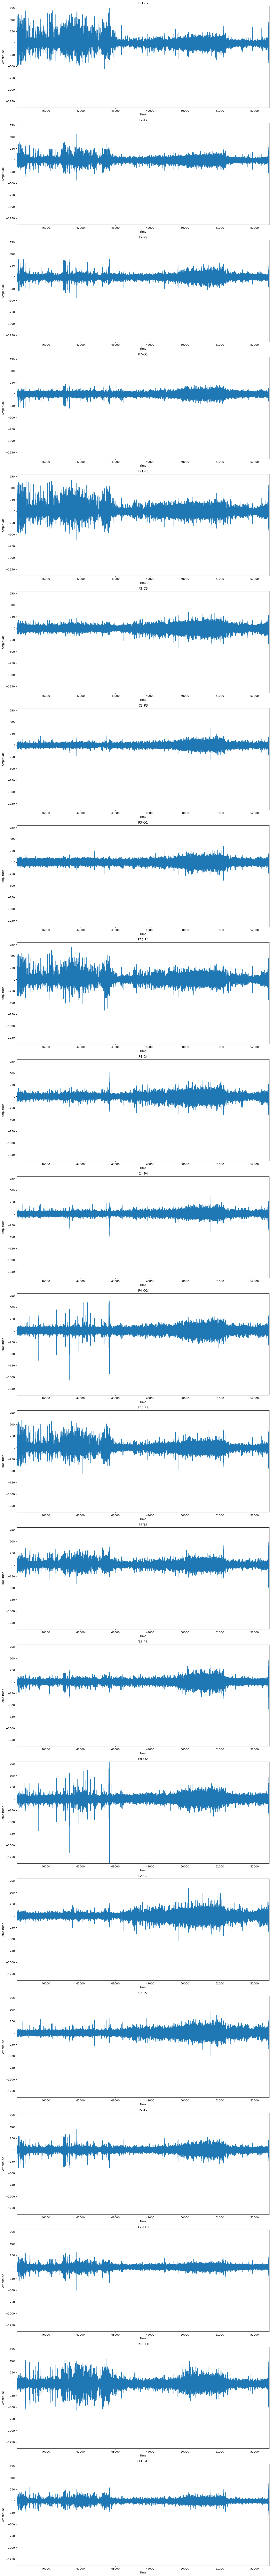

In [29]:
# Affichage
fig, axs = plt.subplots(df.shape[1]-1, 1, figsize=(14, 6*(df.shape[1]-1)))
for i, col in enumerate(df.columns[:-1]):
    axs[i].plot(df.index, df[col])
    axs[i].set_title(col)
    axs[i].set_ylim(ylim)
    axs[i].set_xlim(xlim)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')
for point in change_points:
    for i in range(df.shape[1]-1):
        axs[i].axvline(x=df.index[point], color='r')
plt.tight_layout()
plt.show()

## Téléchargement de la figure

In [30]:
# Chemin de téléchargement
filename = os.path.basename(all[crise_nb - 1]).replace('.csv','.png')
im_path = f"C:/Users/Alexia/Desktop/Data/Images/Images_brutes/{filename}"

In [31]:
# Téléchargement
fig.savefig(im_path)

## Téléchargement de tous les fichiers et de toutes les figures

In [32]:
# # Téléchargement des csv
# visu.telechargement_all(description_path, patient_nb, patients_path, Duree_D)

In [33]:
# # Téléchargement des figures
# visu.telechargement_figure_all(description_path, patient_nb, patients_path)